In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/LLaMa')

# LLaMA🦙

A family of **Autoregressive Large Language Model(LLM)**, developed by *Meta-AI*.

### 1. Loading Pre-trained Model (7B) and Inference Function

In [3]:
"""Import Packages"""

import torch
from typing import Optional
import time
from pathlib import Path
import json
from sentencepiece import SentencePieceProcessor
from tqdm import tqdm
from model import ModelArgs, Transformer


In [4]:
"""Class to load pre-trained weights from Meta and Inference Function"""
class LLaMa:

    def __init__(self, model: Transformer, tokenizer: SentencePieceProcessor, args: ModelArgs):

        self.model = model
        self.tokenizer = tokenizer
        self.args = args

    @staticmethod
    def build(checkpoint_dir: str, tokenizer_path: str, max_seq_len: int, max_batch_size: int, load_model: bool, device: str):
        prev_time = time.time()
        if load_model:
            checkpoints = sorted(Path(checkpoint_dir).glob('*.pth'))
            assert len(checkpoints) > 0, f"No checkpoints are found in {checkpoint_dir}"
            ckpt_path = checkpoints[0]
            print(f'Loading checkpoint path "{ckpt_path}"')
            pre_checkpoint = torch.load(ckpt_path, map_location = 'cpu')
            print(f'Loaded checkpoints in {time.time() - prev_time:.2f}s')
            prev_time = time.time()

        with open(Path(checkpoint_dir) / "params.json", "r") as f:
            params = json.loads(f.read())

        args: ModelArgs = ModelArgs(max_seq_length = max_seq_len, max_batch_size = max_batch_size, device = device, **params)

        tokenizer = SentencePieceProcessor()
        tokenizer.load(tokenizer_path)
        args.vocab_size = tokenizer.vocab_size()

        if device == "cuda":
            torch.set_default_tensor_type(torch.cuda.HalfTensor)
        else:
            torch.set_default_dtype(torch.float16)

        model = Transformer(args)

        if load_model:
            del pre_checkpoint['rope.freqs']
            model.load_state_dict(pre_checkpoint, strict = True)
            print(f'Loaded Model State dict in {time.time() - prev_time:.2f}s')

        return LLaMa(model, tokenizer, args)

    def sample_top_p(self, probs: torch.Tensor, top_p: float):

        probs_sort, probs_idx = torch.sort(probs, dim = -1, descending = True)
        probs_sum = torch.cumsum(probs_sort, dim = -1)
        mask = probs_sum - probs_sort > top_p
        probs_sort[mask] = 0.0
        probs_sort.div_(probs_sort.sum(dim = -1, keepdim = True))
        next_token = torch.multinomial(probs_sort, num_samples = 1)
        next_token = torch.gather(probs_idx, -1, next_token)

        return next_token

    def text_completion(self, prompts: list[str], temperature: float = 0.6, top_p: float = 0.9, max_gen_len: Optional[int] = None):

        if max_gen_len is None:
            max_gen_len = self.args.max_seq_length - 1


        prompt_tokens = [self.tokenizer.encode(prompt, out_type = int, add_bos = True, add_eos = False) for prompt in prompts]
        batch_size = len(prompt_tokens)
        assert batch_size <= self.args.max_batch_size, f"Batch size must be less than or equal to {self.args.max_batch_size}"
        max_prompt_len = max(len(prompt) for prompt in prompt_tokens)
        assert max_prompt_len <= self.args.max_seq_length, f"Sequence length must be less than or equal to {self.args.max_seq_length}"
        total_len = min(self.args.max_seq_length, max_gen_len + max_prompt_len)

        pad_id = self.tokenizer.pad_id()
        tokens = torch.full((batch_size, total_len), pad_id, dtype = torch.long, device = self.args.device)
        for k, t in enumerate(prompt_tokens):
            tokens[k, :len(t)] = torch.tensor(t, dtype = torch.long, device = self.args.device)

        eos_reached = torch.tensor([False] * batch_size, device = self.args.device)
        prompt_tokens_mask = tokens != pad_id
        pos_iterator = tqdm(range(1, total_len), desc = "Generating Tokens")
        for pos in pos_iterator:
            with torch.no_grad():
                logits = self.model.forward(tokens[:, pos - 1:pos], pos)

            if temperature > 0:
                probs = torch.softmax(logits[:, -1] / temperature, dim = -1)
                next_token = self.sample_top_p(probs, top_p)
            else:
                next_token = torch.argmax(logits[:, -1], dim = -1)

            next_token = next_token.reshape(-1)

            next_token = torch.where(prompt_tokens_mask[:, pos], tokens[:, pos], next_token)
            tokens[:, pos] = next_token

            eos_reached |= (~prompt_tokens_mask[:, pos]) & (next_token == self.tokenizer.eos_id)
            if all(eos_reached):
                break

        out_tokens = []
        out_text = []
        for prompt_index, current_prompt_tokens in enumerate(tokens.tolist()):
            if self.tokenizer.eos_id in current_prompt_tokens:
                eos_idx = current_prompt_tokens.index(self.tokenizer.eos_id)
                current_prompt_tokens = current_prompt_tokens[:eos_idx]
            out_tokens.append(current_prompt_tokens)
            out_text.append(self.tokenizer.decode(current_prompt_tokens))
        return (out_tokens, out_text)


In [5]:
if torch.cuda.is_available():
      for i in range(torch.cuda.device_count()):
          print(torch.cuda.get_device_properties(i))
allow_cuda = True
device = 'cuda' if torch.cuda.is_available() and allow_cuda else 'cpu'
device

'cpu'

In [6]:
model = LLaMa.build(
        checkpoint_dir = '/content/drive/MyDrive/LLaMa/llama-2-7b/',
        tokenizer_path = '/content/drive/MyDrive/LLaMa/tokenizer.model',
        max_seq_len = 1024,
        max_batch_size = 3,
        load_model = True,
        device = device
    )

Loading checkpoint path "/content/drive/MyDrive/LLaMa/llama-2-7b/consolidated.00.pth"
Loaded checkpoints in 122.34s


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


Loaded Model State dict in 81.49s


In [7]:
"""Example Prompt"""
prompts = [
          "Simply put, the theory of relativity states that "
          ]

In [8]:
torch.manual_seed(1)
out_tokens, out_texts = (model.text_completion(prompts, max_gen_len = 64))
assert len(out_texts) == len(prompts)

Generating Tokens: 100%|██████████| 76/76 [08:22<00:00,  6.61s/it]


In [9]:
for i in range(len(out_texts)):
    for word in f'{out_texts[i]}':
      sys.stdout.write(word)
      time.sleep(0.01)
    print()
    print('-' * 100)

Simply put, the theory of relativity states that 1) the speed of light is the same for all observers, regardless of their motion, and 2) the laws of physics are the same for all observers, regardless of their motion.ŋ
### History
The theory of relativity is based on the work of Galileo and Newton, who
----------------------------------------------------------------------------------------------------


## 2. Creating Gradio App for Inference

In [10]:
! pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.7 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=

In [11]:
import gradio as gr

In [12]:
title = '🦙🔗LLaMA'
# Define another string variable to hold the description of the app
description = 'This application demonstrates the use of the open-source LLaMA2 from scratch'

In [15]:
# Create generate function - this will be called when a user runs the gradio app
def generate(prompt):
    # The prompt will get passed to the LLM model!
    _, out_texts = model.text_completion([prompt], max_gen_len = 64)
    for text in out_texts:
      return text
    # And will return responses

In [16]:
# Build gradio interface, define inputs and outputs...just text in this
gr.Interface(fn = generate, inputs = ["text"], outputs = ["text"],
             # Pass through title and description
             title = title, description = description,
             # Set theme and launch parameters
             theme = 'finlaymacklon/boxy_violet').launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ee35f8041012d8a8b0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)



![App](<attachment:Screenshot2024-02-18 153104.png>)
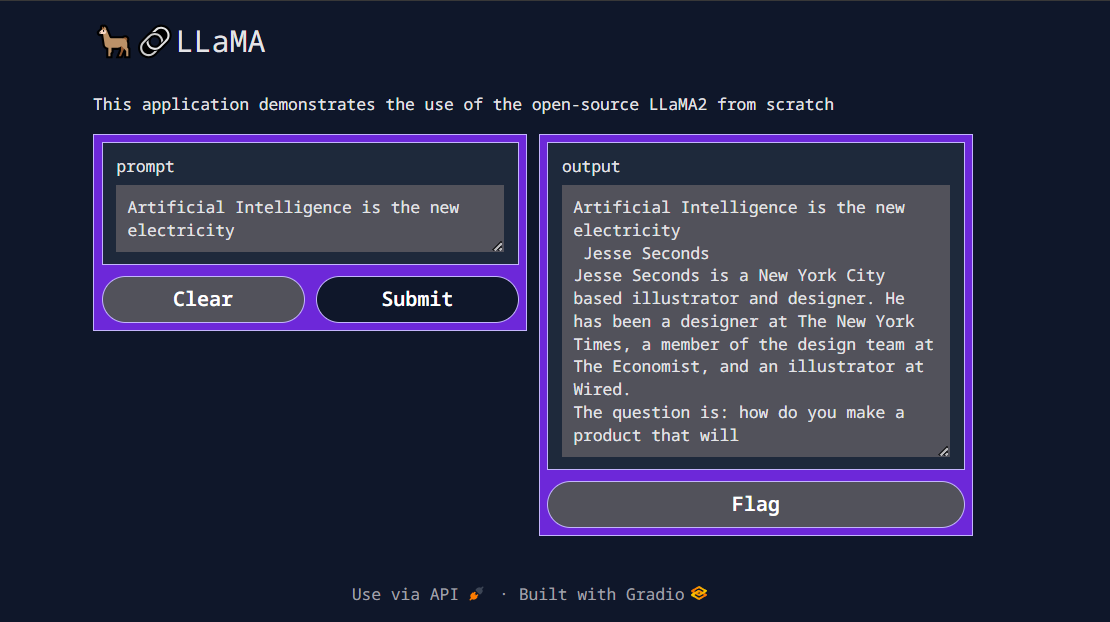

## 3. References:
1. [LLaMA Theory](https://youtu.be/Mn_9W1nCFLo?si=da5zjOm59f3UqhuY).
2. [YouTube](https://youtu.be/oM4VmoabDAI?si=LemgplfImDcjuY1A).
3. [GitHub](https://github.com/facebookresearch/llama).